# Ecological models: relevant?
## NIOZ Master Thesis Project

This Jupyter Notebook contains a detailed description and workflow to train two machine learning models for my thesis. Every section is denoted with a second level heading to keep track of my experiments. First the data from the EBT Tool is imported - a deterministic population model resembling a tri-trophic system in the Baltic Sea (Van Leeuwen et al., 2008). This data is used to train two machine learning models (TCDF and PCMCI respectively) to infer (ecological) causal relations. Both are convolutional machine learning models, and able to handle non-stationary temporal data. 

Author: R. Draaijer

## Prologue

Run these cells prior to running any cell below, in order for the script and models to function in a proper way.

In [1]:
# Install libraries

import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from IPython.display import display, HTML

# Ignore warnings 
pd.options.mode.chained_assignment = None

# Set figure size
plt.rcParams['figure.figsize'] = [25, 10]

In [2]:
# Create universally (i.e. across various operating systems) recognized paths

notebook_path = os.path.abspath('Experiments Notebook.ipynb')          # Jupyter notebook path
TCDF_path = os.path.join(os.path.dirname(notebook_path), 'TCDF')       # TCDF folder path
TCDFdata_path = os.path.join(TCDF_path, 'data')                        # TCDF/data folder path
EBT_path = os.path.join(os.path.dirname(notebook_path), 'EBT Data')    # EBT folder path
DefaultCod_path = os.path.join(EBT_path, 'Modified Default Cod')       # EBT/Modified Default Cod folder path
Cod_path = os.path.join(DefaultCod_path, 'Modified Default.out')       # EBT/Modified Default Cod/Modified Default.out file path

In [3]:
# Install conda- and pip packages in the current Jupyter kernel

!conda install -c anaconda tensorflow --y
!pip3 install torch torchvision torchaudio
!{sys.executable} -m pip install torchvision

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
# Load clean data from EBT tool into DataFrame
file_path = os.path.join(TCDFdata_path, 'EBT_dataset.csv')
ebt = pd.read_csv(file_path, delimiter = ',', header = 0)

# Define labels
labels = ['Time (year)',
          'Rs', 'Rj', 'Ra',                               # Shared resources biomass
          'Sj', 'Sa', 'Sb',                               # Sprat stages biomass
          'Cj', 'Ca', 'Cb',                               # Cod stages biomass
          'Fc']
biomass_labels = ['Rs', 'Rj', 'Ra',                       # Shared resources biomass
                  'Sj', 'Sa', 'Sb',                       # Sprat stages biomass
                  'Cj', 'Ca', 'Cb',                       # Cod stages biomass
                  'Fc']

ebt = ebt[labels]

In [5]:
# Define function for visualisation of scaled data 

def plot_data(data, years):                      # Add argument 'transformation', for (non)scaling methods
    """This function plots selected data within given timeframe [years] for the triptrophic community. 
    Provided data should be a DataFrame with at least columns [Cj, Ca, Cb, Sj, Sa, Sb, Rj, Rs, Ra].
    The years argument is given as a list with two numbers between 0 and 100."""
    
    # Select data to be visualized
    cod = data[['Cj', 'Ca', 'Cb']]
    sprat = data[['Sj', 'Sa', 'Sb']]
    resource = data[['Rj', 'Rs', 'Ra']]
    data['Time'] = np.linspace(years[0], years[1], len(data))
    time = data['Time']

    # Set subplot figure defaults
    fig, [cod_plt, sprat_plt, resource_plt] = plt.subplots(3, 1, sharex = True)
    fig.subplots_adjust(hspace = 0)
    fig.suptitle('Cod-sprat-resource dynamics {start}-{stop} years (scaled)'.format(start=years[0],stop=years[1]))

    # Set labels for shared x-axis and individual y-axes
    cod_plt.set(ylabel = 'Cod biomass')
    sprat_plt.set(ylabel = 'Sprat biomass')
    resource_plt.set(ylabel = 'Resource biomass')
    plt.xlabel('Time (years)')

    # Visualize data
    cod_plt.plot(time, cod)
    sprat_plt.plot(time, sprat)
    resource_plt.plot(time, resource)

    # Add legends
    cod_plt.legend(['Cj', 'Ca', 'Cb'], loc = 'center left')
    sprat_plt.legend(['Sj', 'Sa', 'Sb'], loc = 'center left')
    resource_plt.legend(['Rj', 'Rs', 'Ra'], loc = 'center left')

    # Remove Time column
    data.drop(['Time'], axis = 1, inplace = True)

In [6]:
# Define function that preprocesses (i.e. scale min-max) and select data from desired timeframe 

def select_data(data, start, stop, preprocessor='min-max'):        
    """This function preprocesses selected data.
    Three processing methods can be used (min-max, standard, power transf) - min-max default.
    Selection of data timeframe is specified with the [start] and [stop] arguments."""

    # Select information of datapoints
    selected_data = data[(data['Time (year)'] >= start) & (data['Time (year)'] <= stop)]

    # Normalize data
    # Min-max normalization
    if preprocessor == 'min-max':
        scaler = MinMaxScaler()
    # Power transformer normalization
    elif preprocessor == 'power transf':
        scaler = PowerTransformer()  
    # Standard normalization
    elif preprocessor == 'standard':
        scaler = StandardScaler()
    
    scaled = scaler.fit_transform(selected_data[biomass_labels])
    
    # Write scaled data to DataFrame
    processed_data = pd.DataFrame(scaled, columns = biomass_labels)

    # Check the scaled DataFrame
    display(processed_data.head(-10))
    # Plot scaled data 
    plot_data(processed_data, [start,stop])
    
    return processed_data

In [7]:
# Define function to plot the model's loss or accuracy (i.e. performance) after running 

def plot_performance(losses_or_accuracy):
    """This function plots the losses for each trained variable for the TCDF model.
    Takes a dictionary with either losses or accuracy for each variable as input"""
    
    # Preallocate plots in subplots
    fig, axs = plt.subplots(3, 3, sharex = True)
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Performance measure')

    # Iterate over each key in dictionary
    keys = list(losses_or_accuracy.keys())
    
    # Plot every variable in different subplot
    axs[0, 0].plot(np.arange(len(losses_or_accuracy[keys[0]])), losses_or_accuracy[keys[0]])
    axs[0, 0].set_title('Performance Rs')
    axs[0, 1].plot(np.arange(len(losses_or_accuracy[keys[1]])), losses_or_accuracy[keys[1]])
    axs[0, 1].set_title('Performance Rj')
    axs[0, 2].plot(np.arange(len(losses_or_accuracy[keys[2]])), losses_or_accuracy[keys[2]])
    axs[0, 2].set_title('Performance Ra')
    axs[1, 0].plot(np.arange(len(losses_or_accuracy[keys[3]])), losses_or_accuracy[keys[3]])
    axs[1, 0].set_title('Performance Sj')
    axs[1, 1].plot(np.arange(len(losses_or_accuracy[keys[4]])), losses_or_accuracy[keys[4]])
    axs[1, 1].set_title('Performance Sa')
    axs[1, 2].plot(np.arange(len(losses_or_accuracy[keys[5]])), losses_or_accuracy[keys[5]])
    axs[1, 2].set_title('Performance Sb')
    axs[2, 0].plot(np.arange(len(losses_or_accuracy[keys[6]])), losses_or_accuracy[keys[6]])
    axs[2, 0].set_title('Performance Cj')
    axs[2, 1].plot(np.arange(len(losses_or_accuracy[keys[7]])), losses_or_accuracy[keys[7]])
    axs[2, 1].set_title('Performance Ca')
    axs[2, 2].plot(np.arange(len(losses_or_accuracy[keys[8]])), losses_or_accuracy[keys[8]])
    axs[2, 2].set_title('Performance Cb')


In [8]:
# Define function for adding white noise
def noise(signal, snr):
    """This function adds white Gaussian noise to a signal.
    Noise is added to existing signal and created by a desired signal-to-noise ratio (SNR).
    Function returns the original signal with added noise by the given SNR."""

    # Set mean noise to 0, indicative for white noise
    mean_noise = 0
    sample = len(signal)
    
    # Calculate averages to determine signal power
    average_mean = np.mean(signal)
    average_snr = (10 * np.log10(average_mean)) - snr    
    average_noise = 10 ** (average_snr / 10)

    # Generate noisy signal
    noise_variation = np.random.normal(mean_noise, np.sqrt(average_noise), sample)
    
    # Add noise to the original signal
    noise_signal = signal + noise_variation
    
    return noise_signal

In [9]:
# Define function for creating noisy dataset
def noisy_data(snr):

    # Create dataframe for noisy data
    noisy_ebt = pd.DataFrame(ebt)

    # Add noise for relevant columns
    for col in ebt[biomass_labels]:
        noisy_ebt[col] = noise(ebt[col], snr)

    # Visualise unscaled and scaled data 
    plot_data(noisy_ebt, [0,100])
    
    # Write the final dataset to DataFrame named noisy_ebt
    noisy_ebt['Time (year)'] = ebt['Time (year)']
    
    return noisy_ebt

In [10]:
# Define needed directory
directory = TCDF_path

# Check current working directory
current_directory = os.getcwd()

# Change working directory to perform TCDF
if current_directory != directory:
    os.chdir(TCDF_path)

# Check new current working directory
os.getcwd()

'C:\\Users\\10528504\\Documents\\GitHub\\thesis\\TCDF'

This part shows the functionality of TCDF.

See the corresponding paper for more detail: ["Causal Discovery with Attention-Based Convolutional Neural Networks"](https://www.mdpi.com/2504-4990/1/1/19).

# TCDF

These next code cells perform the analysis of the (demo) dataset with the TCDF. In the utils.py file you are able to adjust parameters for adaptive learning rate and early stopping. These parameters include type of optimizer (specified in runTCDF.py arguments), number of epochs before adapting learning rate, minimum learning rate, and size of decreasing learning rate factor. For early stopping two parameters are given, the number of epochs before stopping when loss is not improving and the minimum difference in loss improvement.

In [11]:
# Show all argument options

%run -i "runTCDF.py" --help

usage: runTCDF.py [-h] [--cuda] [--epochs EPOCHS] [--kernel_size KERNEL_SIZE]
                  [--hidden_layers HIDDEN_LAYERS]
                  [--learning_rate LEARNING_RATE] [--optimizer {Adam,RMSprop}]
                  [--log_interval LOG_INTERVAL] [--seed SEED]
                  [--dilation_coefficient DILATION_COEFFICIENT]
                  [--significance SIGNIFICANCE] [--plot]
                  (--ground_truth GROUND_TRUTH | --data DATA [DATA ...])
                  [--lr_scheduler] [--early_stopping]

TCDF: Temporal Causal Discovery Framework

optional arguments:
  -h, --help            show this help message and exit
  --cuda                Use CUDA (GPU) (default: False)
  --epochs EPOCHS       Number of epochs (default: 1000)
  --kernel_size KERNEL_SIZE
                        Size of kernel, i.e. window size. Maximum delay to be
                        found is kernel size - 1. Recommended to be equal to
                        dilation coeffient (default: 4)
  --hidden_

## TCDF Training

In this section I will tweak (hyper)parameters and save the best outcomes thus far. After implementation of a learning rate scheduler and early stopping to help the process of training the model (see the ~.py files in the TCDF folder, any adjustments are highlighted by '# Adjusted implementation by Draaijer, R.'). Besides, I have also implemented some extra code to save predictive accuracy of the model to plot the performance of the model after the run. Each run is accompanied by two plots (losses and accuracy) to keep track of training the model. 

### TCDF with EBT demo data
#### TCDF: first run

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.95)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.316403
Epoch    29: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.003015
Epoch: 500 [50%] 	Loss: 0.000343
Epoch: 750 [75%] 	Loss: 0.000097
Epoch: 1000 [100%] 	Loss: 0.000054
Potential causes:  [8, 2]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.088712
Epoch    14: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000577
Epoch: 500 [50%]

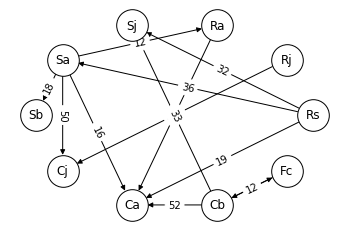

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline

# Run TCDF with the selected demo dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 1000 --log_interval 250 --significance 0.95 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot

#### TCDF: second run (1 extra hidden layer; dilation coefficient and kernel size incremented with 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.942532
Epoch   114: reducing learning rate of group 0 to 1.0000e-02.
Epoch   125: reducing learning rate of group 0 to 1.0000e-03.
Epoch   136: reducing learning rate of group 0 to 1.0000e-04.
Epoch   147: reducing learning rate of group 0 to 1.0000e-05.
Epoch   158: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.000971
Epoch: 500 [50%] 	Loss: 0.000965
INFO: Early stopping
Potential causes:  [4, 1]
Validated causes:  [4]

 Analysis started for target:  Rj
INFO: Initializing

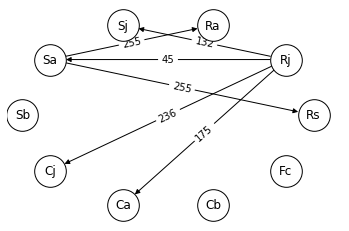

<Figure size 432x288 with 0 Axes>

In [13]:
%matplotlib inline

# Run TCDF with the selected demo dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot

#### TCDF: third run (kernel size & dilation coefficient decreased with 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.236588
Epoch   146: reducing learning rate of group 0 to 1.0000e-02.
Epoch   157: reducing learning rate of group 0 to 1.0000e-03.
Epoch   168: reducing learning rate of group 0 to 1.0000e-04.
Epoch   179: reducing learning rate of group 0 to 1.0000e-05.
Epoch   190: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.001544
Epoch: 500 [50%] 	Loss: 0.001502
INFO: Early stopping
Potential causes:  [3, 4]
Validated causes:  [3]

 Analysis started for target:  Rj
INFO: Initializing

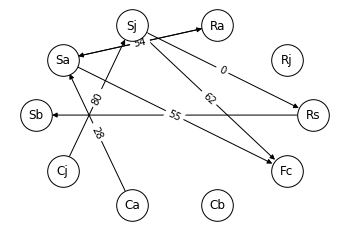

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline

# Run TCDF with the selected demo dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_demo_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.281714
Epoch   103: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000050
Epoch: 500 [50%] 	Loss: 0.000021
Epoch: 750 [75%] 	Loss: 0.000006
Epoch: 1000 [100%] 	Loss: 0.000004

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.014514
Epoch    22: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000186
Epoch: 500 [50%] 	Loss: 0.000111
Epoch: 750 [75%] 	Loss: 0.000081
Epoch: 1000 [100%] 	Loss: 0.000061

 Analysis started for target:  Ra
INFO: Init

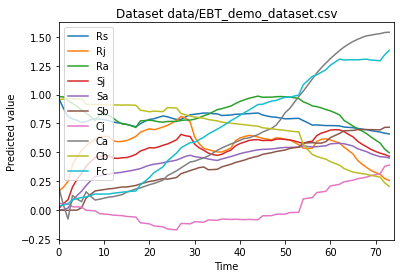

<Figure size 432x288 with 0 Axes>

In [15]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_demo_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot

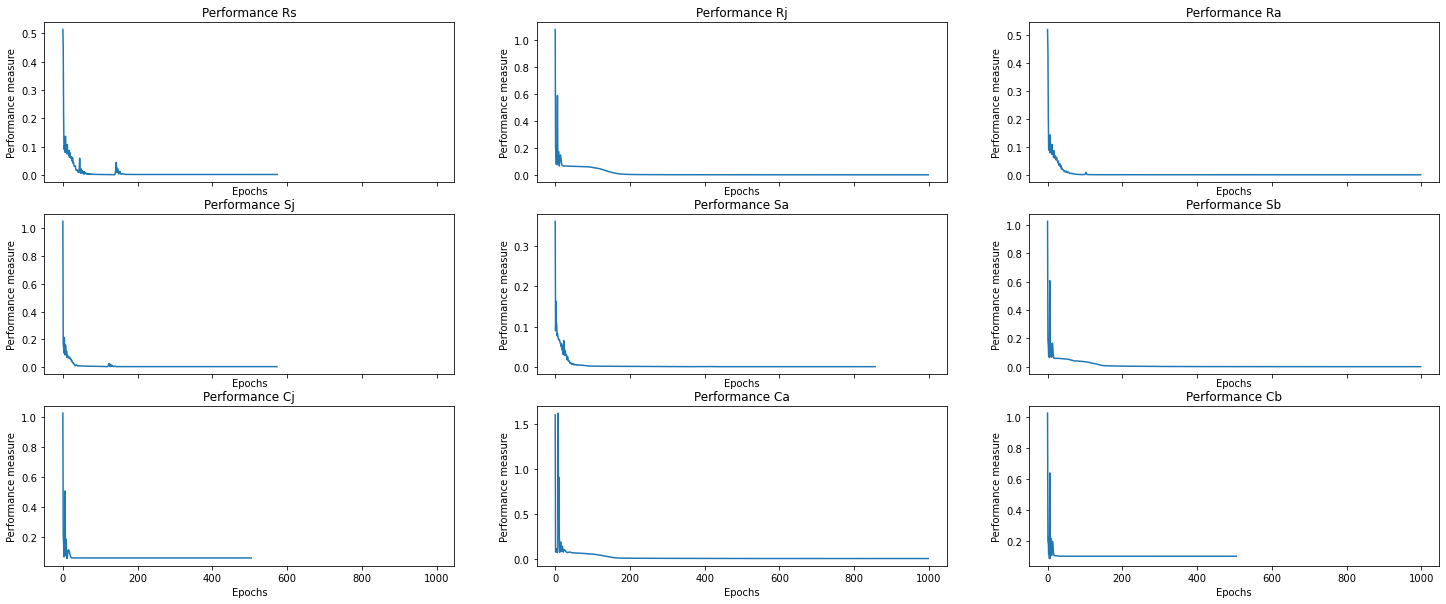

In [16]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

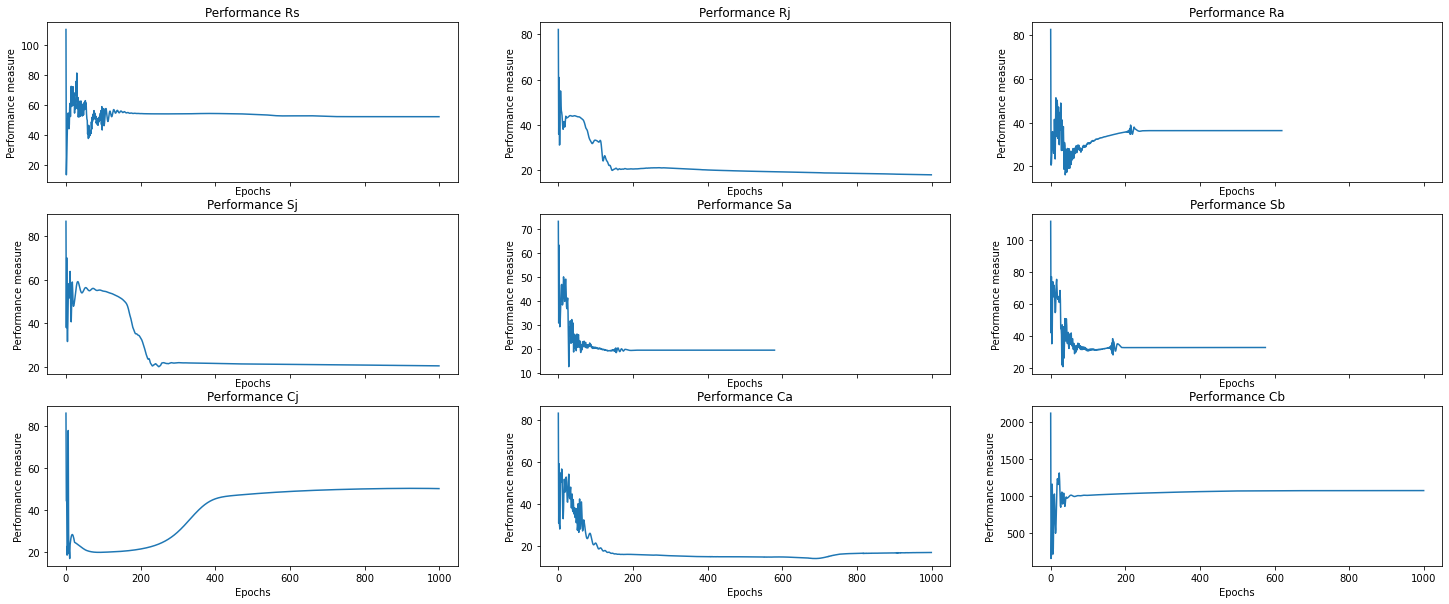

In [17]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF: fourth run (different seed)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=500, lr_scheduler=True, optimizer='Adam', plot=True, seed=1111, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.777512
Epoch    24: reducing learning rate of group 0 to 1.0000e-02.
Epoch   351: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 500 [50%] 	Loss: 0.000254
Epoch: 1000 [100%] 	Loss: 0.000187
Potential causes:  [0, 6, 1]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.314598
Epoch   100: reducing learning rate of group 0 to 1.0000e-02.
Epoch   111: reducing learning rate of group 0 to 1

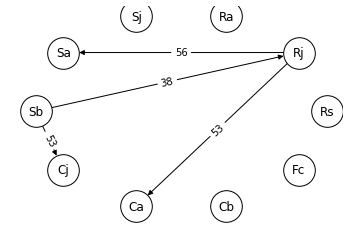

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline

# Run TCDF and evaluate by comparing the results to the ground truth

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_demo_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=500, lr_scheduler=True, optimizer='Adam', plot=True, seed=1111, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.922410
Epoch   146: reducing learning rate of group 0 to 1.0000e-02.
Epoch   157: reducing learning rate of group 0 to 1.0000e-03.
Epoch   168: reducing learning rate of group 0 to 1.0000e-04.
Epoch   179: reducing learning rate of group 0 to 1.0000e-05.
Epoch   190: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 500 [50%] 	Loss: 0.000283
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.160367
Epoch   147: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 500 

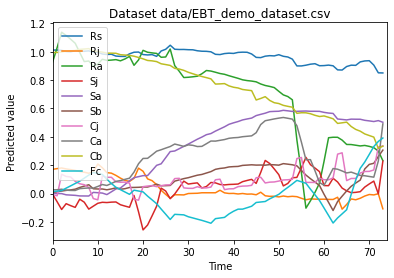

<Figure size 432x288 with 0 Axes>

In [19]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_demo_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.8

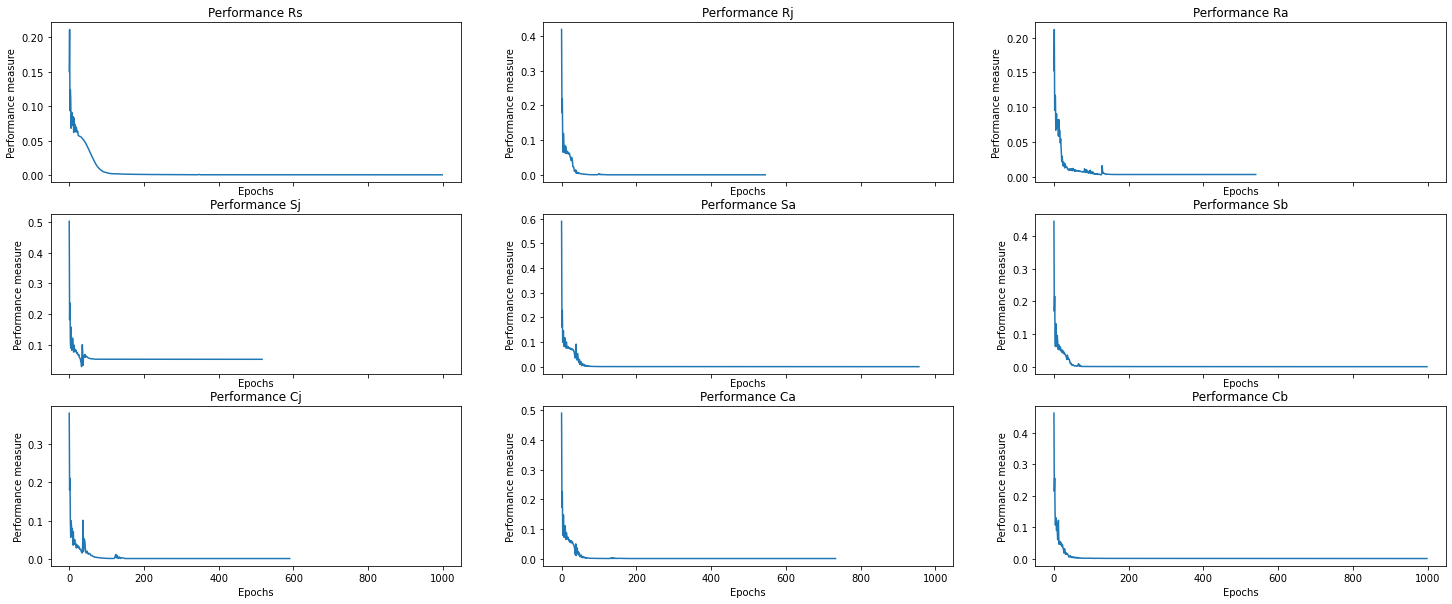

In [20]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

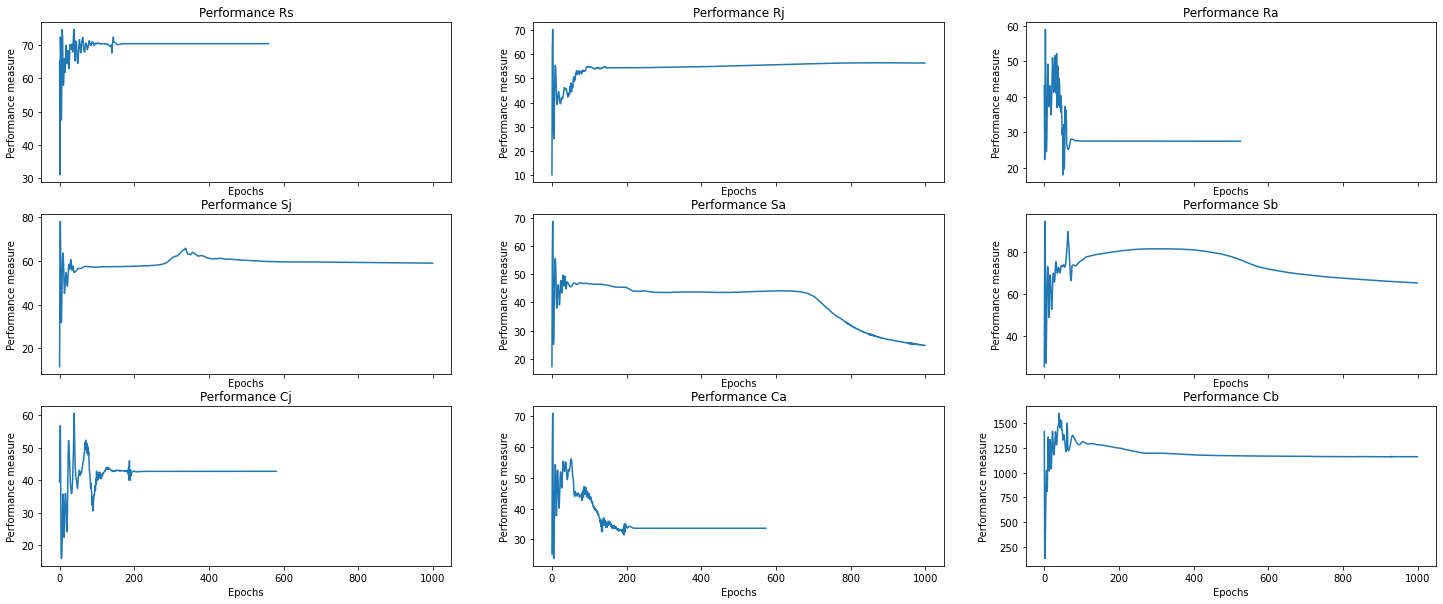

In [21]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF: fourth run (different seed)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_demo_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=25942, significance=0.9)

 Dataset:  EBT_demo_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.620090
Epoch   129: reducing learning rate of group 0 to 1.0000e-02.
Epoch   140: reducing learning rate of group 0 to 1.0000e-03.
Epoch   151: reducing learning rate of group 0 to 1.0000e-04.
Epoch   162: reducing learning rate of group 0 to 1.0000e-05.
Epoch   173: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.000822
Epoch: 500 [50%] 	Loss: 0.000821
INFO: Early stopping
Potential causes:  [8, 4]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Initializing

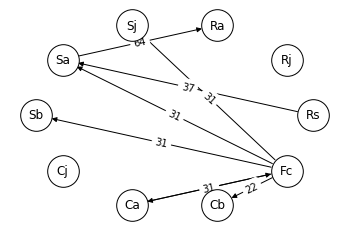

<Figure size 432x288 with 0 Axes>

In [22]:
%matplotlib inline

# Run TCDF and evaluate by comparing the results to the ground truth

%run -i "runTCDF.py"  --ground_truth data/EBT_demo_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 25942 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_demo_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=25942, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.742122
Epoch   208: reducing learning rate of group 0 to 1.0000e-02.
Epoch   219: reducing learning rate of group 0 to 1.0000e-03.
Epoch   230: reducing learning rate of group 0 to 1.0000e-04.
Epoch   241: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 250 [25%] 	Loss: 0.000299
Epoch   252: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 500 [50%] 	Loss: 0.000298
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.093288
Epoch    18: reducing learning rate of 

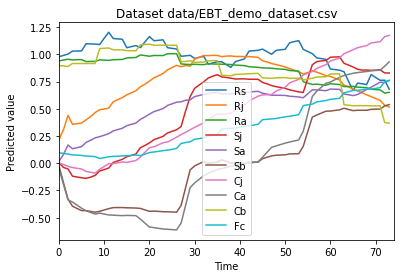

<Figure size 432x288 with 0 Axes>

In [23]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_demo_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 25942 --plot --train_test_split 0.8

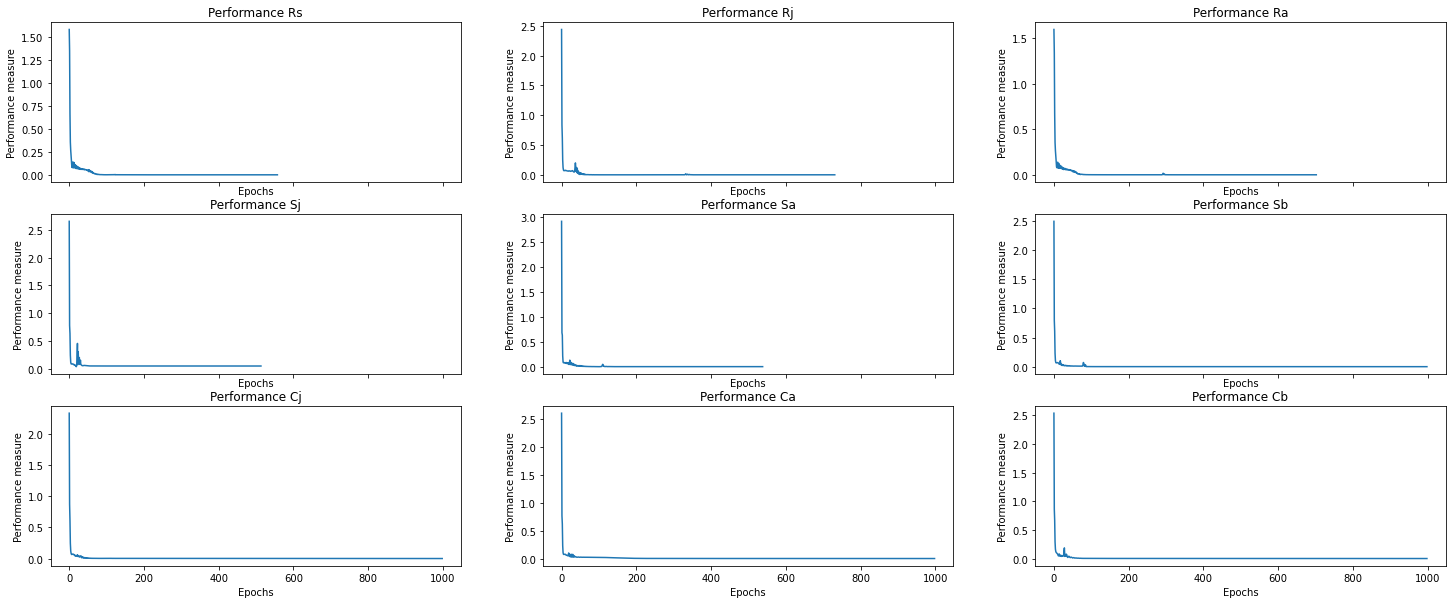

In [24]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

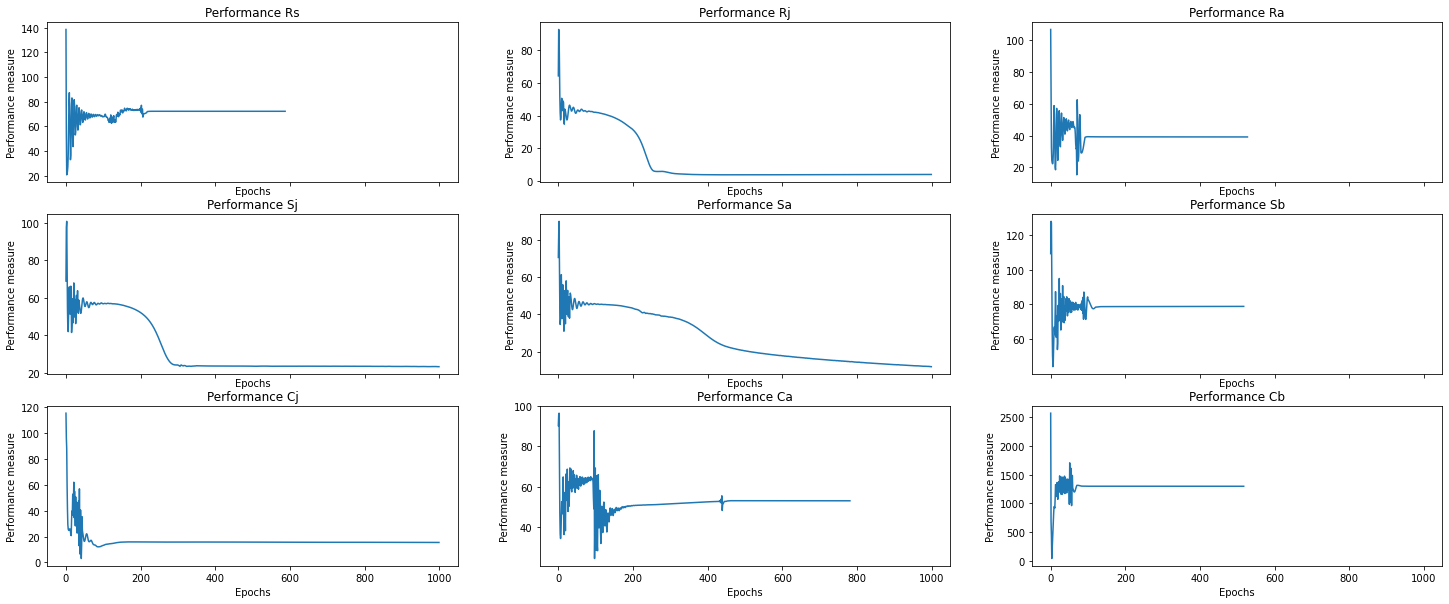

In [25]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

There seems to be big differences in performance and loss when changing the seed, this indicates an unstable pattern and have to find better (hyper)parameters. Or maybe because there is too little data for now?

# Start of Experiments

## Min Max Scaling

### Signal to Noise ratio 1:0

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### 20 - 70 years

Rs        Rj        Ra        Sj        Sa        Sb        Cj  \
0      1.00000  0.018127  0.646078  0.441177  0.000017  0.459337  0.879586   
1      1.00000  0.018127  0.646078  0.441177  0.000017  0.459337  0.879586   
2      1.00000  0.018127  0.646078  0.441177  0.000017  0.459337  0.879586   
3      1.00000  0.018127  0.646079  0.441177  0.000017  0.459337  0.879586   
4      1.00000  0.018127  0.646079  0.441177  0.000017  0.459337  0.879586   
...        ...       ...       ...       ...       ...       ...       ...   
18236  0.00003  0.999801  0.999999  0.000081  0.999837  0.000260  0.000056   
18237  0.00003  0.999815  0.999999  0.000075  0.999849  0.000241  0.000052   
18238  0.00003  0.999829  0.999999  0.000069  0.999861  0.000222  0.000048   
18239  0.00003  0.999844  0.999999  0.000063  0.999872  0.000204  0.000044   
18240  0.00003  0.999858  0.999999  0.000058  0.999884  0.000185  0.000040   

                 Ca        Cb        Fc  
0      2.027708e-01  1.000000  0.000000  
1      2.027707e-01  0.999999  0.000068  
2      2.027705e-01  0.999997  0.000137  
3      2.027703e-01  0.999993  0.000205  
4      2.027699e-01  0.999987  0.000274  
...             ...       ...       ...  
18236  3.579564e-07  0.000043  0.000000  
18237  3.559397e-07  0.000043  0.000000  
18238  3.539230e-07  0.000043  0.000000  
18239  3.519088e-07  0.000043  0.000000  
18240  3.498946e-07  0.000043  0.000000  

[18241 rows x 10 columns]

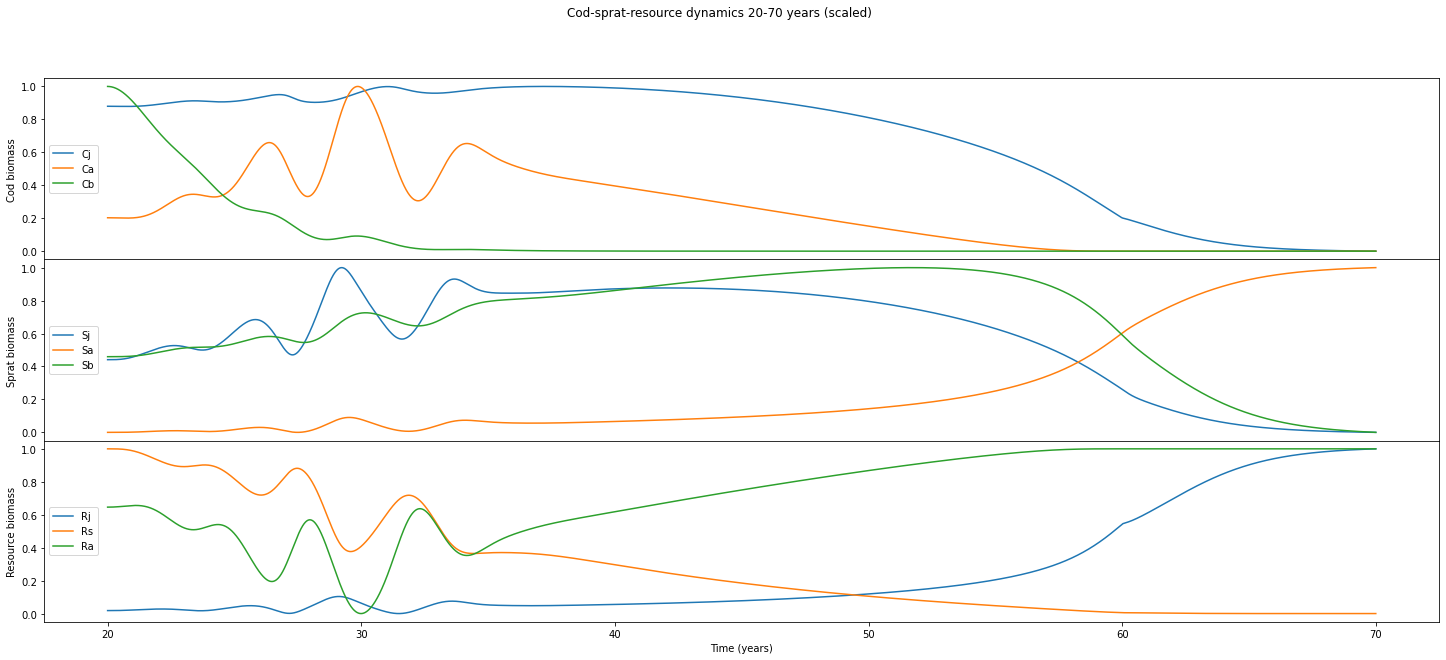

In [26]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_20_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_20_70_dataset.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.097749
Epoch    17: reducing learning rate of group 0 to 1.0000e-02.
Epoch    38: reducing learning rate of group 0 to 1.0000e-03.
Epoch    49: reducing learning rate of group 0 to 1.0000e-04.
Epoch    60: reducing learning rate of group 0 to 1.0000e-05.
Epoch    71: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.101089
Epoch: 500 [50%] 	Loss: 0.100987
INFO: Early stopping
Potential causes:  [2, 3]
Validated causes:  [2, 3]

 Analysis started for target:  Rj
INFO: Initial

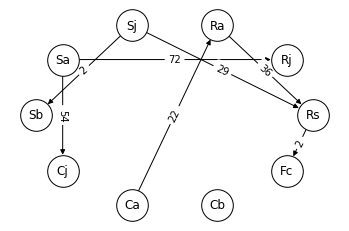

<Figure size 432x288 with 0 Axes>

In [27]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.135261
Epoch    16: reducing learning rate of group 0 to 1.0000e-02.
Epoch   185: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [25%] 	Loss: 0.005052
Epoch: 500 [50%] 	Loss: 0.004591
Epoch: 750 [75%] 	Loss: 0.004216
Epoch: 1000 [100%] 	Loss: 0.003936

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.058924
Epoch    32: reducing learning rate of group 0 to 1.0000e-02.
Epoch    47: reducing learning rate of group 0 to 1.0000e-03.
Epoch    59: reducing learning rate of group 0 to 1.00

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_0_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_20 = select_data(ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_0_20_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_70_100 = select_data(ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_70_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_20_60_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_60_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

## TCDF: Noisy Data

Same exact models are run with noisy data.

### Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise. Three different datasets are provided - SNR 1:0.1, 1:1, 1:10. Each noisy dataset is analysed with optimized (hyper)parameters for the particular dataset to increase performance and accuracy.

### Signal to Noise ratio 1:0.1

In [ ]:
# Create new dataset with snr 1:0.1
noisy_ebt = noisy_data(10)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_20_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_0_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_0_20_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_70_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_20_60_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_60_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:1

In [ ]:
# Create new dataset with snr 1:1
noisy_ebt = noisy_data(1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_20_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_0_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_0_20_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_70_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_20_60_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_60_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:10

In [ ]:
# Create new dataset with snr 1:10
noisy_ebt = noisy_data(0.1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_20_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_0_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_0_20_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_70_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_20_60_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_60_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
## Prologue

# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

## Power Transformer Scaling

### Signal to Noise ratio 1:0

In [ ]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70, 'power transf')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_20_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100, 'power transf')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_0_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
ebt_0_20 = select_data(ebt, 0, 20, 'power transf')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_0_20_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
ebt_70_100 = select_data(ebt, 70, 100, 'power transf')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_70_100_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60,'power transf')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_20_60_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70, 'power transf')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_60_70_dataset.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)